In [35]:
import pandas as pd
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,f1_score,auc,precision_score

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset( ):
    data_path = 'C:/Users/hyunsoo/study/MLstudy/DS_study/ML_Guide/dataset/HAR/'
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv(data_path+'features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv(data_path+'train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv(data_path+'test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv(data_path+'train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv(data_path+'test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

def get_clf_eval(y_test,pred):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    print('confusion matrix')
    print(confusion)
    print('acc: {0:.4f}, prec: {1:.4f}, recall: {2:.4f}, F1: {3:.4f}'.format(accuracy,precision,recall,f1))

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM  
경사하강법을 통해 오류를 최소화한다.  
  
$D(x) = D_{tree1}+D_{tree2}+D_{tree3}$  
$f(x) = D(x) + D_{tree4}$  
$R(x) = f(x) - D(x)$  
위를 경사하강법 반복.  
위처럼 순차적으로 학습하기 때문에, 시간이 오래걸림

|parameters|ex|  
|----------|--|  
|loss|경사하강법에 사용할 비용함수|  
|learning_rate|학습률, n_estimators크게, lr은 작게|  
|n_estimators|weak learner 개수|  
|subsample|데이터 셈플링 비율|

In [4]:
# Gradient Boosting Classifier 불러오기
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.metrics import accuracy_score
import time

# GBM 수행시간 측정을 위함. 시작시간 설정
start_time = time.time()

# 예시 데이터셋 불러오기
gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train.values)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {:.4f}'.format(gb_accuracy))
print('GBM 수행 시간: {:.1f}초'.format(time.time() - start_time))

C:\python_anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GBM 정확도: 0.9389
GBM 수행 시간: 493.6초


In [5]:
# GBM GridSearchCV

from sklearn.model_selection import GridSearchCV

params = {'n_estimators': [100,500],
          'learning_rate':[0.05,1]
         }

grid_cv = GridSearchCV(gb_clf,param_grid=params,cv=2,verbose=1)
grid_cv.fit(X_train,y_train)

print('Best Params:\n',grid_cv.best_params_)
print('Best Acc:{0:.4f}'.format(grid_cv.best_score_))

gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_acc = accuracy_score(y_test,gb_pred)
print(gb_acc)

## XGBoost  
GBM과 다르게 병렬 학습이 가능해 빠르다.  
python 래퍼, sklearn 래퍼가 존재  
  
### python 래퍼 파라미터  
|주요 일반 파라미터| ex|  
|------------------|---|  
|booster|gbtree,gblinear 선택, 디폴트는 트리|  
|silent|출력 메시지 지정|  
|nthread|실행 스레드 개수|  
  
|주요 부스터 파라미터| ex|  
|--------------------|---|  
|eta|기존 learning Rate|  
|num_boost_rounds|GBM의 n_estimators|  
|min_child_weight[default=1]|가지치기를 결정하기 위한 가중치|  
|gamma|리프노드를 추가적으로 나눌지를 결정할 최소 손실|  
|max_depth|tree의 max_depth|  
|sub_sample|gbm의 subsample|  
|colsample_bytree|gbm의 max_features|  
|lambda|L2 Regularization|  
|alpha|L1 Regularization|  
|scale_post_weight|클래스 균형 맞춤|  
  
|학습 태스크 파라미터|ex|  
|--------------------|--|  
|objective|최솟값을 가져야할 손실함수 정의 xgboost부터 손실함수 정의 가능|  
|binary:logistic|이진분류일 때 적용|  
|multi:softmax|다중분류일 때 적용|  
|multi:softprob|다중분류에서 확률 반환|  
|eval_matric|검증에 사용되는 함수 정의|

In [9]:
import xgboost
print(xgboost.__version__)

1.4.2


In [13]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split


dataset = load_breast_cancer()
x_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=x_features,columns=dataset.feature_names)
cancer_df['target'] = y_label

cancer_df.head(5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [37]:
# train-test-split
x_train, x_test, y_train, y_test = train_test_split(x_features,y_label,
                                                    test_size=0.2,random_state=42)

# xgb는 Dmatrix 사용
dtrain = xgb.DMatrix(data=x_train,label=y_train)
dtest = xgb.DMatrix(data=x_test,label=y_test)

params = {'max_depth':3,
          'eta':0.1,
          'objective':'binary:logistic',
          'eval_metric':'logloss',
          'early_stoppings':100
         }
num_rounds = 400

wlist = [(dtrain,'train'),(dtest,'eval')]

xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_rounds,
                     early_stopping_rounds=100, evals=wlist)

[18:45:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.60961	eval-logloss:0.61443
[1]	train-logloss:0.54076	eval-logloss:0.54721
[2]	train-logloss:0.48407	eval-logloss:0.49559
[3]	train-logloss:0.43324	eval-logloss:0.44659
[4]	train-logloss:0.38985	eval-logloss:0.40682
[5]	train-logloss:0.35213	eval-logloss:0.37082
[6]	train-logloss:0.31949	eval-logloss:0.34032
[7]	train-logloss:0.29139	eval-logloss:0.31559
[8]	train-logloss:0.26606	eval-logloss:0.29181
[9]	train-logloss:0.24392	eval-logloss:0.27323
[10]	train-logloss:0.22408	eval-logloss:0.25490
[11]	train-logloss:0.20697	eval-logloss:0.24217
[12]	train-logloss:0.19128	eval-logloss

[162]	train-logloss:0.00734	eval-logloss:0.09851
[163]	train-logloss:0.00732	eval-logloss:0.09860
[164]	train-logloss:0.00730	eval-logloss:0.09849
[165]	train-logloss:0.00728	eval-logloss:0.09851
[166]	train-logloss:0.00726	eval-logloss:0.09859
[167]	train-logloss:0.00725	eval-logloss:0.09815
[168]	train-logloss:0.00721	eval-logloss:0.09793
[169]	train-logloss:0.00720	eval-logloss:0.09809
[170]	train-logloss:0.00718	eval-logloss:0.09798
[171]	train-logloss:0.00716	eval-logloss:0.09767
[172]	train-logloss:0.00714	eval-logloss:0.09763
[173]	train-logloss:0.00712	eval-logloss:0.09752
[174]	train-logloss:0.00710	eval-logloss:0.09760
[175]	train-logloss:0.00709	eval-logloss:0.09749
[176]	train-logloss:0.00707	eval-logloss:0.09726
[177]	train-logloss:0.00705	eval-logloss:0.09741
[178]	train-logloss:0.00703	eval-logloss:0.09730
[179]	train-logloss:0.00702	eval-logloss:0.09689
[180]	train-logloss:0.00700	eval-logloss:0.09697
[181]	train-logloss:0.00698	eval-logloss:0.09687
[182]	train-logloss:

[330]	train-logloss:0.00543	eval-logloss:0.09224
[331]	train-logloss:0.00543	eval-logloss:0.09222
[332]	train-logloss:0.00542	eval-logloss:0.09198
[333]	train-logloss:0.00542	eval-logloss:0.09208
[334]	train-logloss:0.00541	eval-logloss:0.09197
[335]	train-logloss:0.00540	eval-logloss:0.09197
[336]	train-logloss:0.00540	eval-logloss:0.09187
[337]	train-logloss:0.00539	eval-logloss:0.09196
[338]	train-logloss:0.00539	eval-logloss:0.09196
[339]	train-logloss:0.00538	eval-logloss:0.09186
[340]	train-logloss:0.00537	eval-logloss:0.09195
[341]	train-logloss:0.00537	eval-logloss:0.09182
[342]	train-logloss:0.00536	eval-logloss:0.09181
[343]	train-logloss:0.00536	eval-logloss:0.09183
[344]	train-logloss:0.00535	eval-logloss:0.09173
[345]	train-logloss:0.00535	eval-logloss:0.09182
[346]	train-logloss:0.00534	eval-logloss:0.09162
[347]	train-logloss:0.00534	eval-logloss:0.09164
[348]	train-logloss:0.00533	eval-logloss:0.09162
[349]	train-logloss:0.00532	eval-logloss:0.09162
[350]	train-logloss:

In [38]:
pred_probs = xgb_model.predict(dtest)
preds = [1 if x > 0.5 else 0 for x in pred_probs]

get_clf_eval(y_test,preds)

confusion matrix
[[41  2]
 [ 1 70]]
acc: 0.9737, prec: 0.9722, recall: 0.9859, F1: 0.9790


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

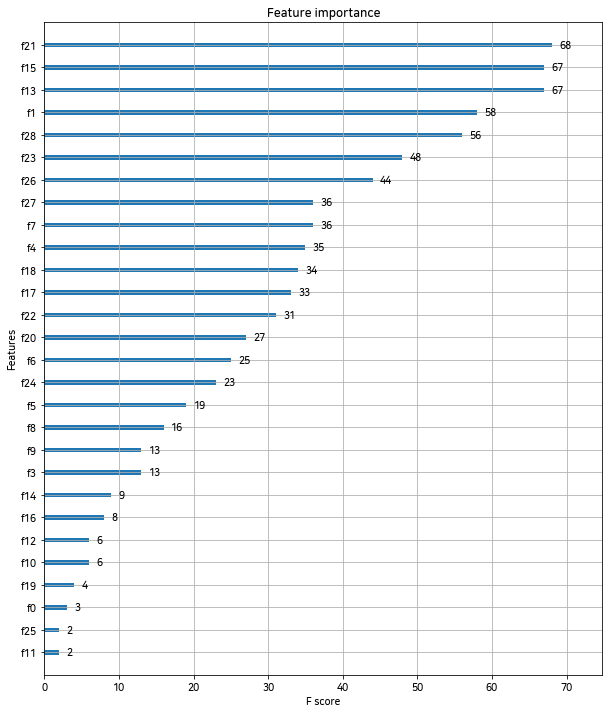

In [39]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)